In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from scipy.stats import norm

In [2]:
### Data Loading
from datasets import FashionMNIST, get_train_loader, get_test_loader

root_dir = "/mnt/d/datasets/fashion_mnist"
train_loader = get_train_loader(dataset=FashionMNIST(root_dir, "train"), batch_size=100)
test_loader = get_test_loader(dataset=FashionMNIST(root_dir, "test"), batch_size=64)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntrain dataset: {len(train_loader.dataset)}, dataloader: {len(train_loader)}")
print(f"train images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"train labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(test_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntest dataset: {len(test_loader.dataset)}, dataloader: {len(test_loader)}")
print(f"test  images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"test  labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")


train dataset: 60000, dataloader: 600
train images: torch.Size([100, 1, 32, 32]), torch.float32, 0.0, 1.0
train labels: torch.Size([100]), torch.int64, 0, 9

test dataset: 10000, dataloader: 157
test  images: torch.Size([64, 1, 32, 32]), torch.float32, 0.0, 1.0
test  labels: torch.Size([64]), torch.int64, 0, 9


In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=2, in_channels=3):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc = nn.Linear(128 * 4 * 4, latent_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc(x)
        return x    # latent

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=2, out_channels=3):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
        )
        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
        )
        self.deconv3 = nn.ConvTranspose2d(32, out_channels,
            kernel_size=3, stride=2, padding=1, output_padding=1)

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 4, 4)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        x = torch.sigmoid(x)    # nn.BCELoss()
        return x    # recon

In [5]:
### Modeling: Autoencoder

class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.loss_fn = nn.BCELoss()

    def forward(self, images):
        latent = self.encoder(images)
        recon = self.decoder(latent)
        return recon, latent

    @property
    def device(self):
        return next(self.parameters()).device

    def train_step(self, batch, optimizer):
        images = batch["image"].to(self.device)
        optimizer.zero_grad()
        recon, latent = self.forward(images)
        loss = self.loss_fn(recon, images)
        loss.backward()
        optimizer.step()
        return dict(loss=loss)

    @torch.no_grad()
    def eval_step(self, images):
        images = batch["image"].to(self.device)
        recon, latent = self.forward(images)
        loss = self.loss_fn(recon, images)
        return dict(loss=loss)

    @torch.no_grad()
    def pred_step(self, batch):
        images = batch["image"].to(self.device)
        labels = batch["label"]
        recon, latent = self.forward(images)
        return dict(image=images, label=labels, latent=latent, recon=recon)

In [6]:
from trainer import fit, evaluate, predict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(latent_dim=2, in_channels=1).to(device)
decoder = Decoder(latent_dim=2, out_channels=1).to(device)
model = Autoencoder(encoder, decoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [7]:
history = fit(model, train_loader, optimizer, num_epochs=10, valid_loader=test_loader)

[  1/10] loss:0.295 | (val) loss:0.262


[  2/10] loss:0.263 | (val) loss:0.255


[  3/10] loss:0.258 | (val) loss:0.253


[  4/10] loss:0.255 | (val) loss:0.253


[  5/10] loss:0.253 | (val) loss:0.249


[  6/10] loss:0.252 | (val) loss:0.248


[  7/10] loss:0.251 | (val) loss:0.247


[  8/10] loss:0.251 | (val) loss:0.246


[  9/10] loss:0.250 | (val) loss:0.245


[ 10/10] loss:0.249 | (val) loss:0.246


In [8]:
evaluate(model, test_loader)

{'loss': 0.24567654728889465}

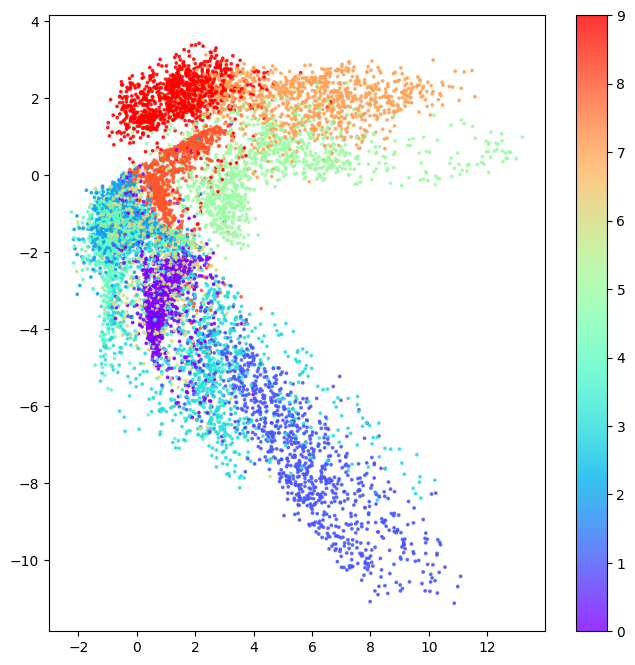

In [9]:
predictions = predict(model, test_loader)
images = predictions["image"]
labels = predictions["label"]
latent = predictions["latent"]
recon  = predictions["recon"]

plt.figure(figsize=(8, 8))
plt.scatter(latent[:, 0], latent[:, 1], cmap="rainbow", c=labels, alpha=0.8, s=3)
plt.colorbar()
plt.show()

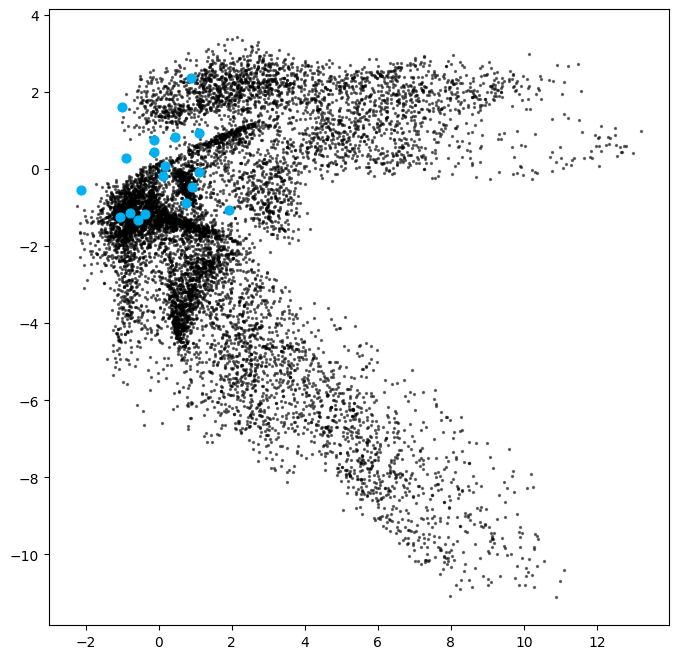

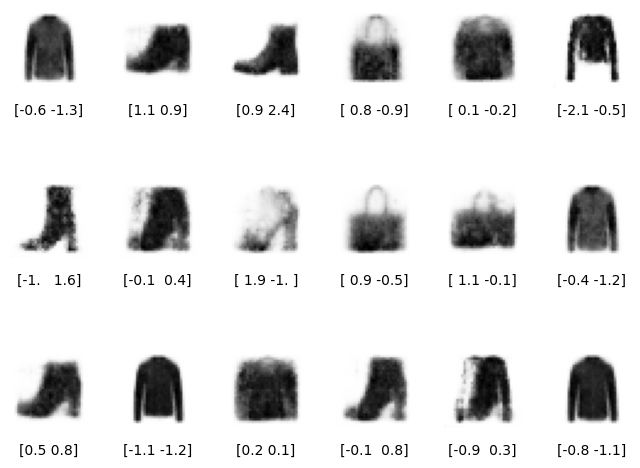

In [10]:
mins, maxs = np.min(latent, axis=0), np.max(latent, axis=0)

grid_width, grid_height = 6, 3
# z_sample = np.random.uniform(mins, maxs, size=(grid_width * grid_height, 2))
z_sample = np.random.normal(size=(grid_width * grid_height, 2))
sample_tensor = torch.tensor(z_sample).float().to(device)
with torch.no_grad():
    reconstructions = decoder(sample_tensor).cpu().permute(0, 2, 3, 1).numpy()

p = norm.cdf(latent)
p_sample = norm.cdf(z_sample)

figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(latent[:, 0], latent[:, 1], c="black", alpha=0.5, s=2)
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()

fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(0.5, -0.35, str(np.round(z_sample[i, :], 1)), fontsize=10, 
        ha="center", transform=ax.transAxes)
    ax.imshow(reconstructions[i, :, :], cmap="Greys")
plt.show()

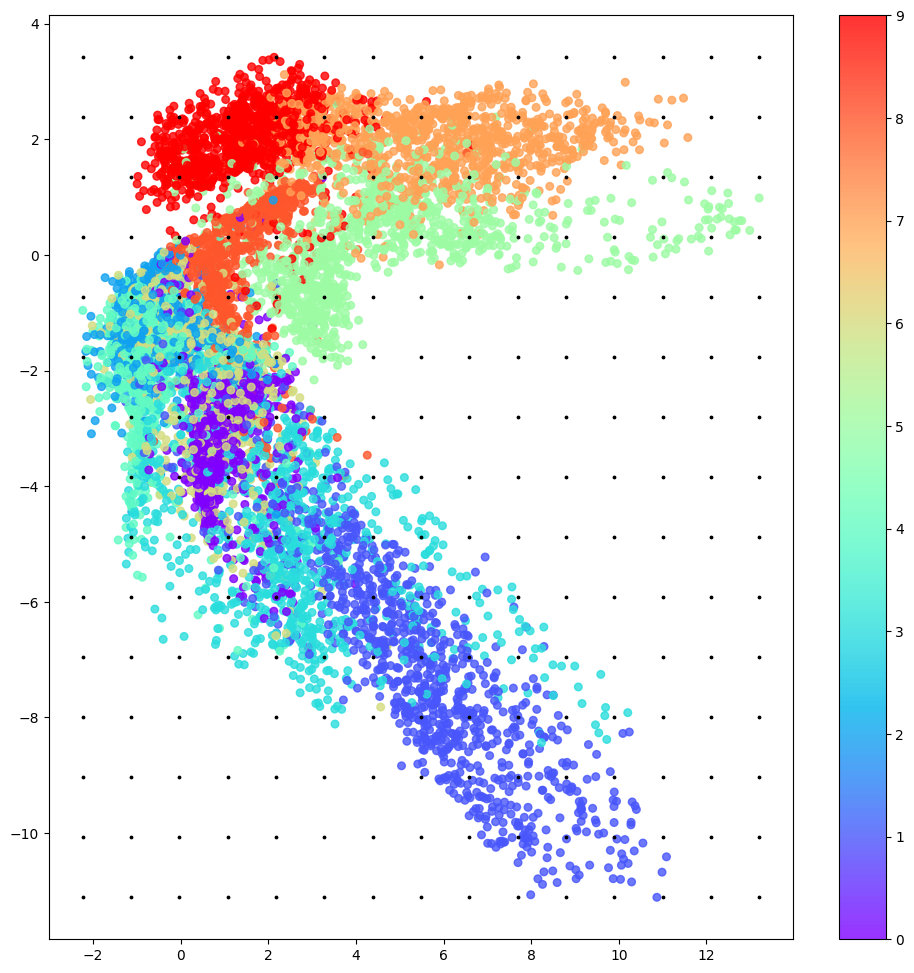

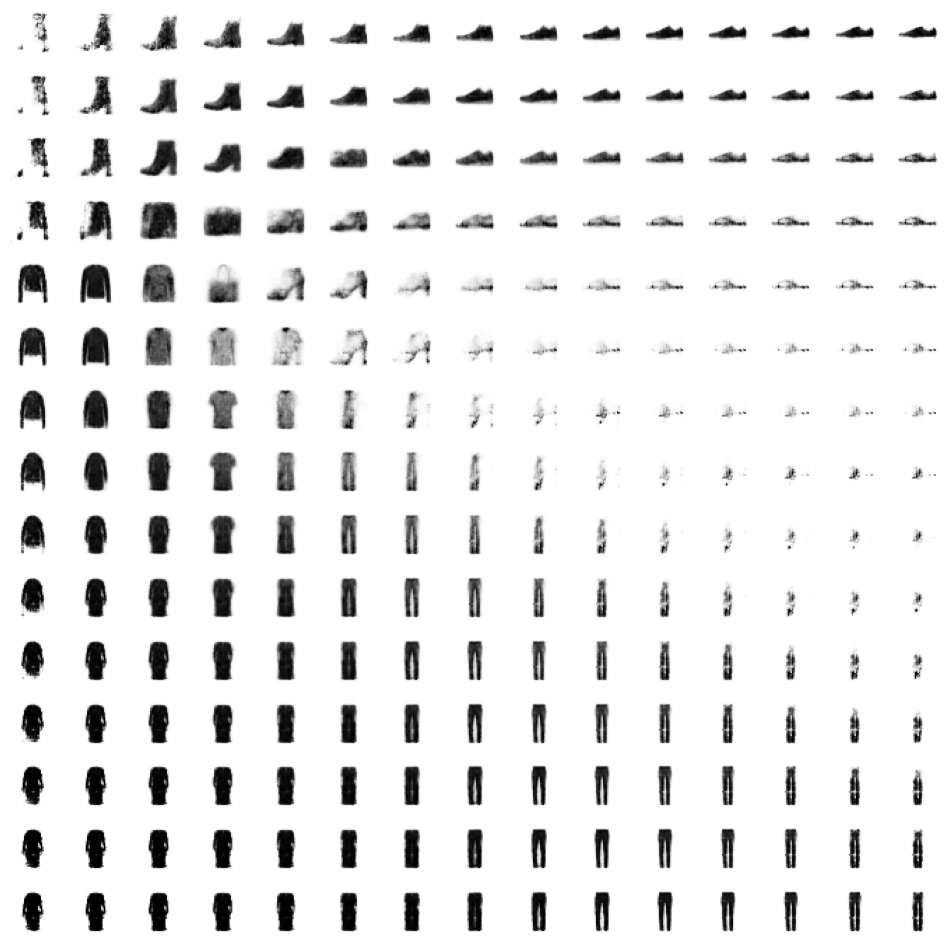

In [11]:
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(latent[:, 0], latent[:, 1], cmap="rainbow", c=labels, alpha=0.8, s=30)
plt.colorbar()

x = np.linspace(min(latent[:, 0]), max(latent[:, 0]), grid_size)
y = np.linspace(max(latent[:, 1]), min(latent[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

grid_tensor = torch.tensor(grid).float().to(device)
with torch.no_grad():
    reconstructions = decoder(grid_tensor).cpu().permute(0, 2, 3, 1).numpy()
plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=3)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

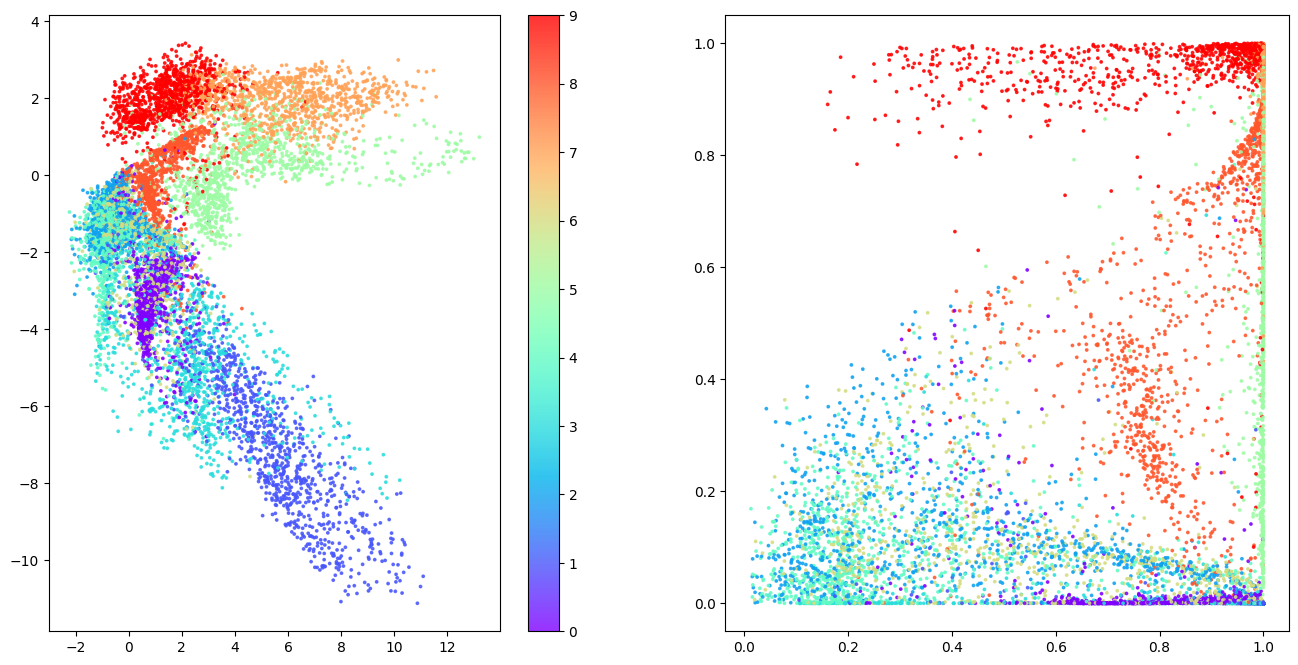

In [12]:
z = latent

figsize = 8
fig = plt.figure(figsize=(figsize * 2, figsize))
ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z[:, 0], z[:, 1], cmap="rainbow", c=labels, alpha=0.8, s=3)
plt.colorbar(plot_1)
ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p[:, 0], p[:, 1], cmap="rainbow", c=labels, alpha=0.8, s=3)
plt.show()

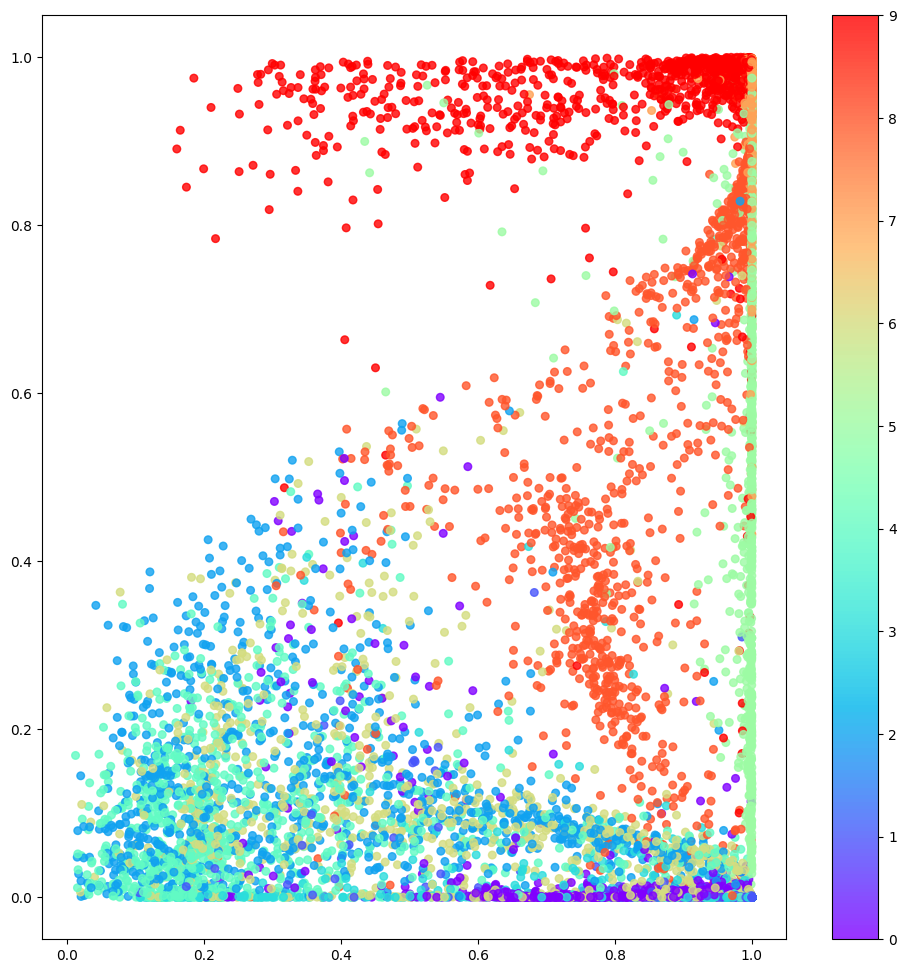

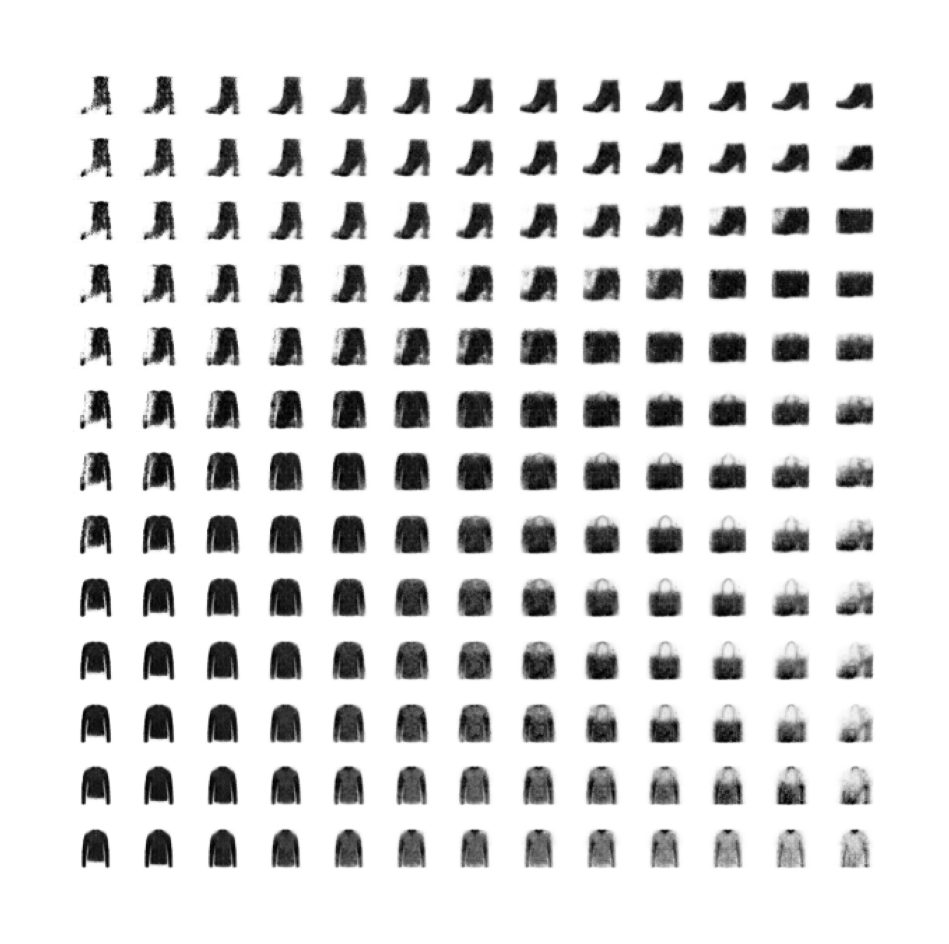

In [13]:
# Colour the embeddings by their label (clothing type - see table)
figsize = 12
grid_size = 15
plt.figure(figsize=(figsize, figsize))
plt.scatter(p[:, 0], p[:, 1], cmap="rainbow", c=labels, alpha=0.8, s=30)
plt.colorbar()

x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

grid_tensor = torch.tensor(grid).float().to(device)
with torch.no_grad():
    reconstructions = decoder(grid_tensor).cpu().permute(0, 2, 3, 1).numpy()
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=3)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.imshow(reconstructions[i, :, :], cmap="Greys")
    ax.axis("off")